In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import ranksums
import os
%matplotlib inline

In [53]:
var_to_plot = "median"
palette = "colorblind"

sims_to_plot = [8,9]
sims_to_plot = [10,11]
sims_to_plot = [14,9,15]
# sims_to_plot = [20]
interp  = [33, 35, 37, 29, 22, 23]
stacked = [32, 34, 36, 28, 20, 21, 38]
sims_to_plot = stacked;
# sims_to_plot = [34,36,38];

context_depth = 1;
nback_depth = 1;
include_tau = True

file_suffix = f"_cd{context_depth}_nb{nback_depth}"
if(not include_tau):
    file_suffix  += f"_no_tau"

parameter_name_map = {"alpha" : "concentration", 
                      "context_similarity_depth_1" : "context weight level 1",
                      "context_similarity_depth_2" : "context weight level 2", 
                      "repeat_bias_1_back" : "repeat bias",
                      "timeconstant_within_session_A" : "time constant"}


sim_name_map = {0 : "sim. 1",
                1 : "sim. 2",
                2 : "sim. 1",
                3 : "sim. 2",
                4 : "OLD pop. sim 1",
                5 : "OLD pop. sim 2",
                6 : "pop. sim 1b",
                7 : "pop. sim 2b",
                8 : "sim. 1",
                9 : "sim. 2",
                10: "pop. sim. 1",
                11: "pop. sim. 2",
                12 : "sim. 3",
                13 : "sim. 4",
                14 : "sim. 1b",
                15 : "sim. 1c",
                20 : "stacked i.i.d -> i.i.d.",
                21 : "stacked markov -> markov",
                22 : "interp i.i.d -> i.i.d.",
                23 : "interp markov -> markov",
                24 : "pre i.i.d.",
                25 : "pre markov",
                26 : "post i.i.d.",
                27 : "post markov",
                28 : "stacked markov2 -> markov2",
                29 : "interp markov2 -> markov2",
                30 : "pre markov2",
                31 : "post markov2",
                
                32 : "stacked i.i.d -> markov",
                33 : "interp i.i.d -> markov",
                34 : "stacked i.i.d -> markov2",
                35 : "interp i.i.d -> markov2",
                36 : "stacked markov -> markov2",
                37 : "interp markov -> markov2",
                38 : "stacked uniform i.i.d -> markov2",}



trial_number_map = lambda x : 10 if x < 8 else 25;

def load_summary(sim, block=None) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, list[int]) :
    df_a  = pd.DataFrame()
    df2_a = pd.DataFrame()

    if(isinstance(sim,int)):
        sim = [sim]
    if(isinstance(block,int)):
        block = [block]
    valid_blocks = []

    if(block is None):
        block = range(1,20+1);
    

    for block_c in block:
        found = False;
        for sim_c in sim:
            filename = f"Results/Simulations/sim_summary_{sim_c}_block_{block_c}{file_suffix}.pkl";
            if(os.path.isfile(filename)):
                df = pd.read_pickle(filename)
                df.index.name = "parameter"
                df = df.reset_index()
                df["simulation"] = sim_c
                df["parameter"] = df["parameter"].map(parameter_name_map).astype("category")
                df["simulation_idx"] = df["simulation"]
                df["simulation"] = df["simulation"].map(sim_name_map)
                df2 = df.pivot(index=["simulation","block","run"],columns=["parameter"], values=[var_to_plot]).droplevel(0,axis=1)

                df_a  = pd.concat([df_a, df])
                df2_a = pd.concat([df2_a,df2])
                if(not found):
                    valid_blocks.append(block_c)
                    found = True
    ms = df2_a.reset_index().groupby(["simulation","block"]).mean()
    return df_a, df2_a, ms, valid_blocks

def load_samples(sim, block):
    df = pd.read_pickle(f"Results/Simulations/sim_{sim}_block_{block}{file_suffix}.pkl")
    df.rename(columns=parameter_name_map, inplace=True)
    df["simulation_idx"] = df["simulation"]
    df["simulation"] = df["simulation"].map(sim_name_map)
    return df


In [54]:
def plot_params_over_blocks(sim,block=None):
    if(isinstance(sim, pd.DataFrame)):
        a = sim;
    else:
        if(isinstance(sim,int)):
            sim = [sim]

        a,_,_,block = load_summary(sim,block)
        a.reset_index();

    xlabel = "trials"



    a[xlabel]  = a["block"].astype(int) * (a["simulation_idx"].apply(trial_number_map))
    
    g = sns.FacetGrid(a, row="parameter", height=1.5, aspect=10/(1.5), sharey=False);

    if(len(a["simulation"].unique()) > 1):
        dodge = 0.1;
    else:
        dodge = None
    g.map_dataframe(sns.pointplot, x=xlabel, y=var_to_plot, errorbar=("pi",90), dodge=dodge, hue="simulation", palette=palette);
    if('true' in a):
        g.map_dataframe(sns.pointplot, x=xlabel, y="true",  linestyles="--", markers="", hue="simulation", palette=palette); #
    g.add_legend()
    for ax in g.axes[:,0]:
        ax.set_ylabel(None);
    
    g.axes[-1,0].set_ylabel('estimate')
    return g;


In [55]:

def plot_params_per_sim(sim,block=None):
    if(isinstance(sim,int)):
        sim = [sim]
    a,_,_,block = load_summary(sim,block)
    assert isinstance(block,int) or len(block)==1, "only one block. Got: " + str(block)
    a.reset_index();

    dodge = 0.2 if len(a["simulation"].unique()) > 1 else False;

    g = sns.FacetGrid(a, col="parameter",  height=4, aspect=1, sharey=False);
    g.map_dataframe(sns.stripplot, x="simulation", hue="simulation", y=var_to_plot, dodge=False, alpha=0.75, palette=palette,size=2); #

    
    if('true' in a):
        g.map_dataframe(sns.pointplot, x="simulation", y="true", dodge=dodge, linestyles="none", markers="d", markersize=6, palette=palette, errorbar=None,linewidth=0.5,alpha=1,  hue="simulation");
    g.map_dataframe(sns.pointplot, x="simulation", y=var_to_plot,
                    dodge=False, linestyles="none", markers="o",
                    markersize=4, palette=palette, errorbar=("pi",90),
                    linewidth=1, alpha=1,  hue="simulation");
    g.set_xticklabels(rotation=45)
    return g;


/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


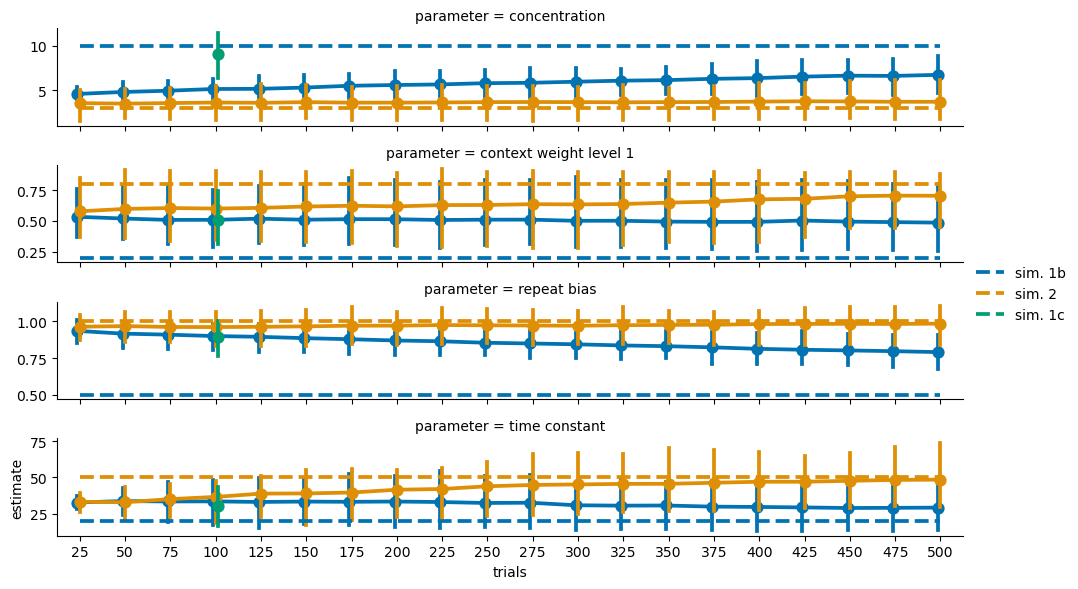

In [56]:
plot_params_over_blocks(sims_to_plot);

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


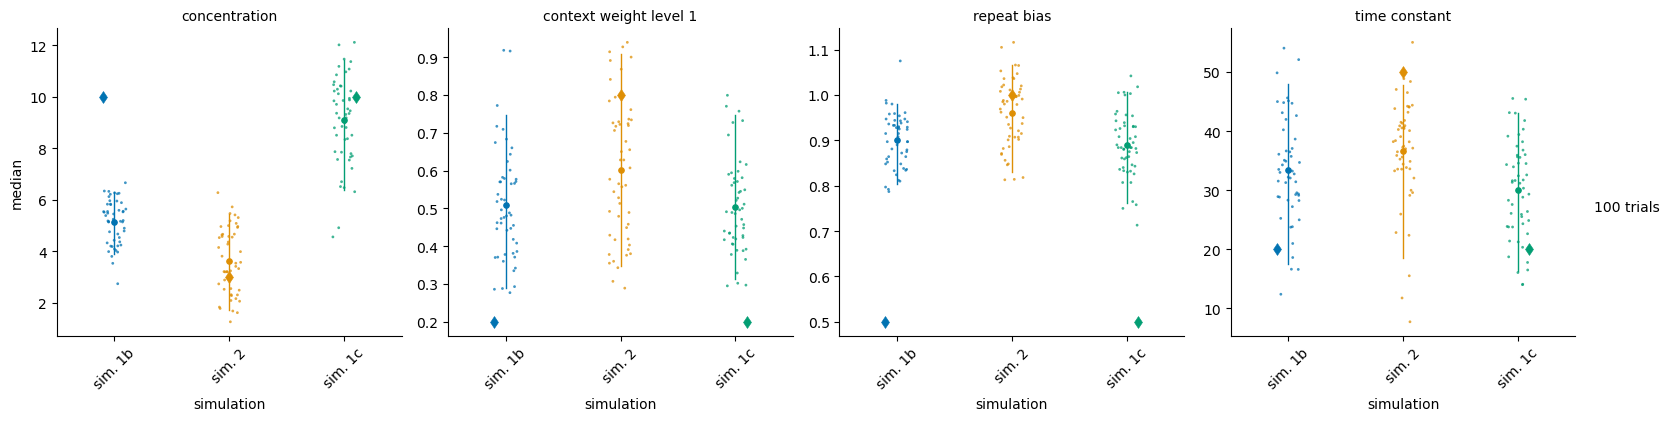

In [58]:
block = 4;
g = plot_params_per_sim(sims_to_plot, block)
NT = block * trial_number_map(sims_to_plot[0]) 
g.set_titles("{col_name}")
g.add_legend(title=f"{NT} trials")